In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

Feature descriptions:
* sex
    - student’s sex (binary: female or male)
* age
    - student’s age (numeric: from 15 to 22)
* school
    - student’s school (binary: Gabriel Pereira or Mousinho da Silveira)
* address
    - student’s home address type (binary: urban or rural)
* Pstatus
    - parent’s cohabitation status (binary: living together or apart)
* Medu
    - mother’s education (numeric: from 0 to 4)
* Mjob
    - mother’s job (nominal)
* Fedu
    - father’s education (numeric: from 0 to 4)
* Fjob
    - father’s job (nominal)
* guardian
    - student’s guardian (nominal: mother, father or other)
* famsize
    - family size (binary: ≤ 3 or > 3)
* famrel
    - quality of family relationships (numeric: from 1 – very bad to 5 – excellent)
* reason
    - reason to choose this school (nominal: close to home, school reputation, course preference or other)
* traveltime
    - home to school travel time (numeric: 1 – < 15 min., 2 – 15 to 30 min., 3 – 30 min. to 1 hour
or 4 – > 1 hour).
* studytime
    - weekly study time (numeric: 1 – < 2 hours, 2 – 2 to 5 hours, 3 – 5 to 10 hours or 4 – > 10 hours)
* failures
    - number of past class failures (numeric: n if 1 ≤ n < 3, else 4)
* schoolsup
    - extra educational school support (binary: yes or no)
* famsup
    - family educational support (binary: yes or no)
* activities
    - extra-curricular activities (binary: yes or no)
* paidclass
    - extra paid classes (binary: yes or no)
* internet
    - Internet access at home (binary: yes or no)
* nursery
    - attended nursery school (binary: yes or no)
* higher
    - wants to take higher education (binary: yes or no)
* romantic
    - with a romantic relationship (binary: yes or no)
* freetime
    - free time after school (numeric: from 1 – very low to 5 – very high)
* goout
    - going out with friends (numeric: from 1 – very low to 5 – very high)
* Walc
    - weekend alcohol consumption (numeric: from 1 – very low to 5 – very high)
* Dalc
    - workday alcohol consumption (numeric: from 1 – very low to 5 – very high)
* health
    - current health status (numeric: from 1 – very bad to 5 – very good)
* absences
    - number of school absences (numeric: from 0 to 93)
* G1
    - first period grade (numeric: from 0 to 20)
* G2
    - second period grade (numeric: from 0 to 20)
* G3
    - final grade (numeric: from 0 to 20)

It seems that most of the features except the last four ones are gathered from a survey. So in my opinion, they might be biased, so the most important features are the last four ones. All of the remaining 29 features might not be bad, I take a guess which ones might be more important, but I will explore the data later for getting certain conclusions.
I would divide features into two groups:
* Explicit features; school-related features that seem directly related to the student's score:
    - absences, G1, G2, failures, studytime, paidclass, activities, higher, nursery, schoolsup, school, reason, traveltime
* Implicit features; features that are not directly related to school but they might affect student's mental situation and as a result the score:
    - Pstatus, Medu, Fedu, Mjob, Fjob, famrel, famsup, romantic, freetime, goout, Walc, Dalc, health

In the first category, in my opinion these features are important: abesnces, failures, studytime, activities. And in the second category: famrel, goout, Walc, Dalc, romantic.

The Student Performance dataset contains students performance on two lessons; math and Portugeese.
First I will load each of them.

In [2]:
student_math = pd.read_csv('data/student-mat.csv', sep=';')
student_por = pd.read_csv('data/student-por.csv', sep=';')

In [3]:
dataset = pd.concat([student_math, student_por])

In [4]:
dataset.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


Now let's I check wether any of the columns contain nan values:

In [5]:
print(f'math missing values: {len(student_math.isna().any()[student_math.isna().any() > 0])}')
print(f'portuguese missing values: {len(student_por.isna().any()[student_por.isna().any() > 0])}')
print(f'math instances: {len(student_math)}, portuguese instances: {len(student_por)}, total instances: {len(dataset)}, ')

math missing values: 0
portuguese missing values: 0
math instances: 395, portuguese instances: 649, total instances: 1044, 


Since some of the features are categorical, we should use a way to encode them. There are multiple approaches for this task like `LabelEncoder` and `OneHotEncoder`. I will use the first one. Bellow I wrote a function that will extract categorical features and encode them with `LabelEncoder`. I will use this function later.

In [6]:
dataset.dtypes[dataset.dtypes == 'object']

school        object
sex           object
address       object
famsize       object
Pstatus       object
Mjob          object
Fjob          object
reason        object
guardian      object
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
dtype: object

In [7]:
def make_quantitative(dataframe):
    categorical_features = list(dataframe.dtypes[dataframe.dtypes == 'object'].index)
    encoder = LabelEncoder()
    for feature in categorical_features:
        dataframe[feature] = encoder.fit_transform(dataframe[feature])
    return dataframe

We have no missing values and the dataset seems clean. We have 1044 total instances and the best approach for such a little dataset is to use a classic machine learning framework, for example, random forest. But since using neural networks is required for this task, I first find important features and use them to train a minimal network.
 
First, I will draw a correlation matrix to see which features are related to each other. Then I will train a RandomForrestClassifier and use the classifier's `feature_importances_` attribute to find the most important features.
 
Since in this phase I am analyzing the data, I will average over students scores to have a single feature representative of the student's performance. I create a new dataframe `new_dataset` and a column `avg_score` that will contain the average score of each student.

In [8]:
new_dataset = dataset.copy()
new_dataset['avg_score'] = (new_dataset['G3'] + new_dataset['G2'] + new_dataset['G1']) / 3
new_dataset.drop(['G1', 'G2', 'G3'], axis=1, inplace=True)

new_math = student_math.copy()
new_math['avg_score'] = (new_math['G3'] + new_math['G2'] + new_math['G1']) / 3
new_math.drop(['G1', 'G2', 'G3'], axis=1, inplace=True)

new_por = student_por.copy()
new_por['avg_score'] = (new_por['G3'] + new_por['G2'] + new_por['G1']) / 3
new_por.drop(['G1', 'G2', 'G3'], axis=1, inplace=True)

Bellow you can see the distribution of the `avg_score` feature in each dataset

<AxesSubplot:ylabel='Density'>

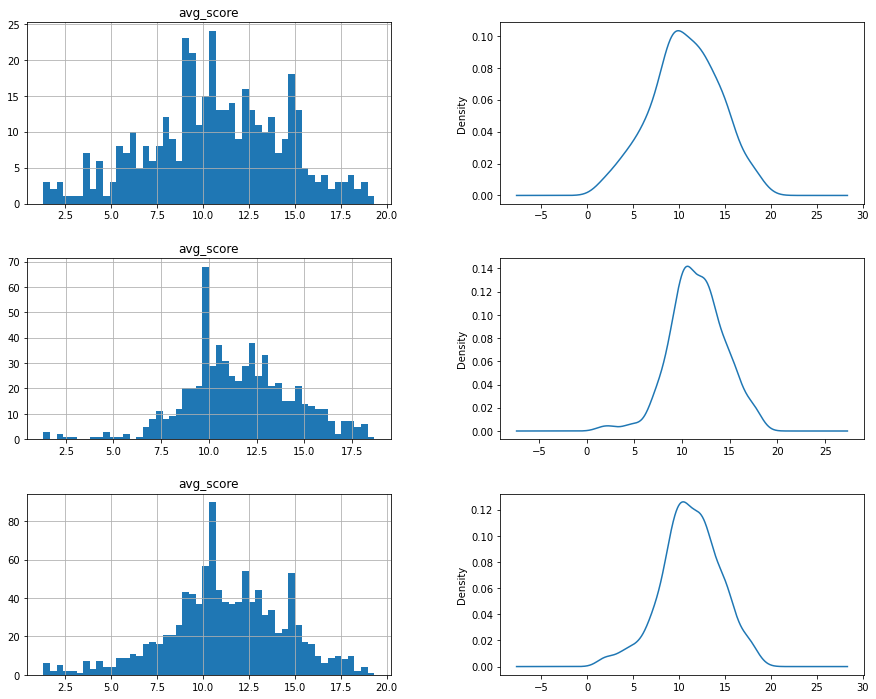

In [9]:
fig, axs = plt.subplots(3,2, figsize=(15,12))

new_math.hist(column='avg_score', bins=50, ax=axs[0][0])
new_math['avg_score'].plot.kde(ax=axs[0][1])

new_por.hist(column='avg_score', bins=50, ax=axs[1][0])
new_por['avg_score'].plot.kde(ax=axs[1][1])

new_dataset.hist(column='avg_score', bins=50, ax=axs[2][0])
new_dataset['avg_score'].plot.kde(ax=axs[2][1])

In [10]:
print(f'portuguese average score: {new_por["avg_score"].mean()}')
print(f'math average score: {new_math["avg_score"].mean()}')
print(f'total average score: {new_dataset["avg_score"].mean()}')

portuguese average score: 11.625064201335388
math average score: 10.67932489451477
total average score: 11.267241379310345


As expected, the average score for Portuguese is higher than math. We will draw the distribution of the `avg_score` feature in each dataset using kernel density estimation which is a non-parametric way to estimate the probability density function of a continuous random variable. Since we have a few instances in each dataset - especially math - and the distribution is not far from normal, I will use the concatenated dataset for convenience.

In [11]:
new_dataset = make_quantitative(new_dataset)

Text(0.5, 1.0, 'Correlation Matrix')

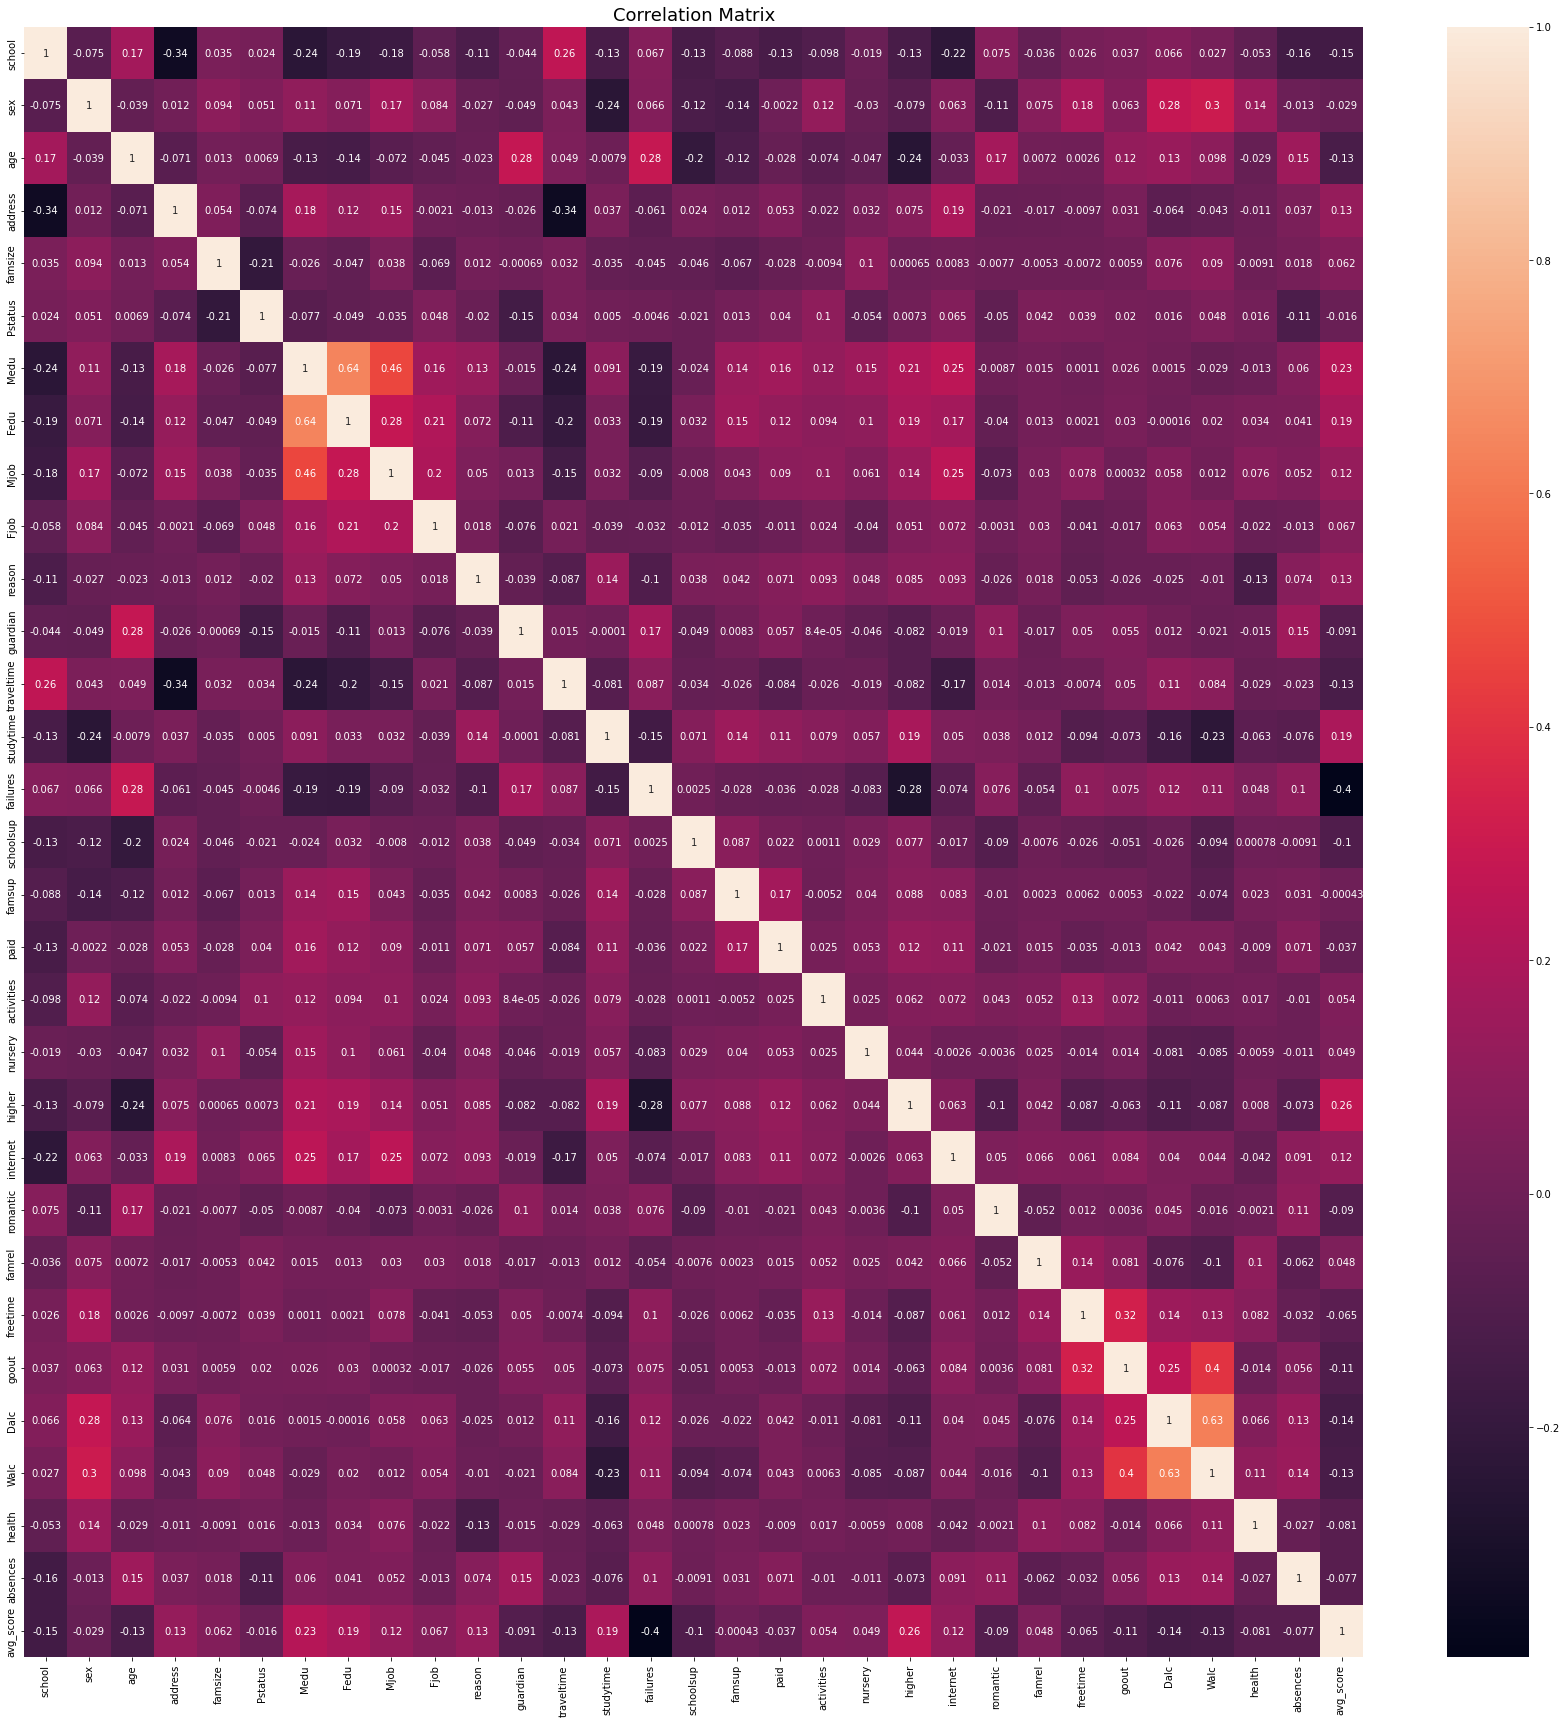

In [12]:
corr = new_dataset.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, annot=True)
plt.title('Correlation Matrix', fontsize=18)

Highly positive correlated features with `avg_score`:

In [13]:
corr['avg_score'].sort_values(ascending=False).iloc[1:8]

higher       0.263819
Medu         0.226919
studytime    0.192288
Fedu         0.186610
reason       0.126673
address      0.125527
Mjob         0.121936
Name: avg_score, dtype: float64

And these are highly negative correlated features:

In [14]:
corr['avg_score'].sort_values(ascending=False).tail(5)

age        -0.129135
Walc       -0.133902
Dalc       -0.143283
school     -0.152406
failures   -0.397262
Name: avg_score, dtype: float64

We can see interesting patterns in the correlation heatmap matrix. We listed mostly correlated features with `avg_score` but the correlations between other features are also worth mentioning.
* `age` is negative correlates with `higher`, it seems older students have less enthusiasm for higher education.
* `Walc` and `Dalc` are negatively correlated with `studytime`, the more they drink the less they study.
* `failure` is negatively correlated with `higher`, the more you fail the less you want to study.
* `walc` and `Dalc` are positively correlated with `sex`, it seems boys are drinking more!
* `goout` is positively correlated with `freetime`
* Parent’s education is highly correlated with their job.
* Parent’s education is highly correlated with whether student has access to the internet or not.
* Going out with friends is highly correlated with drinking alcohol.

In [15]:
_X = new_dataset.drop(['avg_score'], axis=1)
_y = new_dataset['avg_score']

In [16]:
_X_train, _X_test, _y_train, _y_test = train_test_split(_X, _y, test_size = 0.2)

In [17]:
_model = RandomForestRegressor(n_estimators=100, random_state=0)
_model.fit(_X_train, _y_train)
print(mean_squared_error(_y_test, _model.predict(_X_test), squared=False))
feature_importances = pd.Series(_model.feature_importances_, index=_X.columns)

2.621434082456128


In [18]:
feature_importances.sort_values(ascending=False).head(12)

failures     0.170275
absences     0.111090
Fjob         0.056063
goout        0.043318
age          0.041883
health       0.039362
studytime    0.038875
reason       0.037249
Mjob         0.035288
Fedu         0.034219
freetime     0.033789
Medu         0.031781
dtype: float64

Recapping the correlations and the importance of features, I think the following features are the most important ones:
 
`absences`, `failures`, `health`, `studytime`, `goout`, `Fedu`, `Medu`, `higher`, `Walc`, `Dalc`
 
Now I use the dataset for training a neural network. The steps are:
* Make categorical features numeric with the functions that I previously wrote.
* Split the dataset into training and test sets. First taking 90% of data for training and 10% of for testing. Then spliting the training part again into two 90%-10% splits for training and validation.
* To prevent neural network weights and gradients from getting high values, I use Keras Normalization layer which normalizes the data in a way that the standard deviation of each feature is around 1. I will normalize all features (label encoded features). I tried to normalize individual numerical features using scikit-learn's `StandardScaler` but it didn't perform better than the Keras Normalization layer.
* The paper of this dataset (Using data mining to predict secondary school student performance, Cortez et al, 2008) suggests using root mean squared error as regression loss function. So I wrote the custom loss function `rmse_loss` that will be used in the model.
* Since the task is not so complicated and the data is not so big, I will use a simple neural network with one hidden layer. This architecture and hyperparameters were obtained by trial and error.
* I used Keras Checkpoints to save the model's weights after each epoch based on the validation loss. This procedure helps load the model later for inference.
* The rest is model evaluation. The gap between training and test loss is not too big, which shows a good generalization. I can say that by providing more data, we can perform even better.

In [19]:
def standardize(dataframe, columns):
    for col in columns:
        scaler = StandardScaler()
        dataframe[col] = scaler.fit_transform(dataframe[col].values.reshape(-1, 1))
    return dataframe

In [20]:
dataset = make_quantitative(dataset)

In [21]:
train_dataset = dataset.sample(frac=0.9, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [22]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('G3')
test_labels = test_features.pop('G3')

In [23]:
train_dataset.describe()[['age', 'absences', 'failures', 'G1', 'G2', 'G3']].transpose()[['mean', 'std']]

,mean,std
age,16.732979,1.237494
absences,4.394681,6.123557
failures,0.267021,0.657534
G1,11.205319,2.971532
G2,11.270213,3.243633
G3,11.340426,3.869691


In [24]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [25]:
def rmse_loss(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.math.squared_difference(tf.cast(y_true, tf.float32), y_pred)))

In [26]:
def build_and_compile_model(inp):
  model = tf.keras.Sequential([
      inp,
      tf.keras.layers.Dense(3, activation='relu'),
      tf.keras.layers.Dense(1)
  ])
  model.compile(loss= rmse_loss,
                optimizer=tf.keras.optimizers.Adam(0.005))
  return model

In [27]:
model = build_and_compile_model(normalizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 32)                65        
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 168
Trainable params: 103
Non-trainable params: 65
_________________________________________________________________


In [28]:
checkpoint = ModelCheckpoint(filepath='best_model', mode='min', monitor='val_loss', verbose=1, save_best_only=True)
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=1,
    epochs=200,
    callbacks=[checkpoint])

Epoch 1/200
27/27 [==============================] - 0s 4ms/step - loss: 11.5992 - val_loss: 10.9444

Epoch 00001: val_loss improved from inf to 10.94440, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets
Epoch 2/200
27/27 [==============================] - 0s 1ms/step - loss: 10.6100 - val_loss: 9.9090

Epoch 00002: val_loss improved from 10.94440 to 9.90901, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets
Epoch 3/200
27/27 [==============================] - 0s 1ms/step - loss: 9.6964 - val_loss: 8.8514

Epoch 00003: val_loss improved from 9.90901 to 8.85135, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets
Epoch 4/200
27/27 [==============================] - 0s 1ms/step - loss: 8.8443 - val_loss: 7.8877

Epoch 00004: val_loss improved from 8.85135 to 7.88772, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets
Epoch 5/200
27/27 [==============================] - 0s

In [29]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('RMSE Loss')
  plt.legend()
  plt.grid(True)

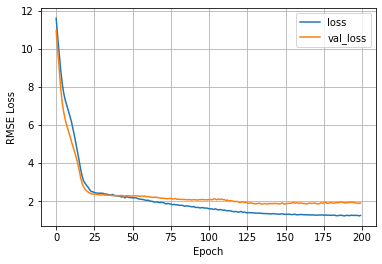

In [30]:
plot_loss(history)

In [31]:
model.load_weights('best_model')
print(f'Train Loss: {min(history.history["loss"])}')
print(f'Validation Loss: {min(history.history["val_loss"])}')
print(f'Test Loss: {model.evaluate(test_features, test_labels, verbose=0)}')

Train Loss: 1.2144049406051636
Validation Loss: 1.83307683467865
Test Loss: 1.322788119316101


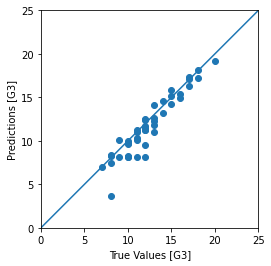

In [32]:
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [G3]')
plt.ylabel('Predictions [G3]')
lims = [0, 25]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

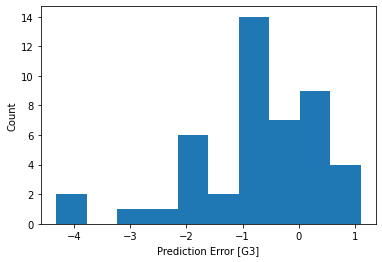

In [33]:
error = test_predictions - test_labels
plt.hist(error, bins=10)
plt.xlabel('Prediction Error [G3]')
_ = plt.ylabel('Count')